<a href="https://colab.research.google.com/github/kanru-wang/GAN_and_Diffusion_models/blob/main/variational_autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Layer, Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D,
    Dense, Flatten, InputLayer, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [2]:
BATCH_SIZE = 128
LATENT_DIM = 2

(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

train_dataset

11490434/11490434 [==============================] - 0s 0us/step


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Modeling

## Encoder

In [3]:
class Sampling(Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return mean + tf.math.exp(0.5 * log_var) * tf.random.normal(shape=(tf.shape(mean)[0], tf.shape(mean)[1]))


encoder_inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean, log_var])

encoder_model = Model(encoder_inputs, [z, mean, log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

## Decoder

In [4]:
latent_inputs = Input(shape=(LATENT_DIM,))
x = Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
decoder_model = Model(latent_inputs, decoder_output, name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Overall VAE Model

In [5]:
vae_input = Input(shape=(28, 28, 1), name="vae_input")
z, _, _ = encoder_model(vae_input)
output = decoder_model(z)
vae = Model(vae_input, output, name="vae")
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_input (InputLayer)      [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


# Training

In [6]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20


def custom_loss(y_true,y_pred,mean,log_var):
    loss_rec = tf.reduce_mean(
        tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1, 2))
    )
    loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss_rec + tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))


class VAE(tf.keras.Model):
    def __init__(self, encoder_model, decoder_model):
        super(VAE, self).__init__()
        self.encoder=encoder_model
        self.decoder=decoder_model
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')


    @property
    def metrics(self):
        return [self.loss_tracker]


    # Overriding train_step method
    def train_step(self, x_batch):
        with tf.GradientTape() as recorder:
            z, mean, log_var = encoder_model(x_batch)
            y_pred = decoder_model(z)
            y_true = x_batch
            loss = custom_loss(y_true, y_pred, mean, log_var)
        
        partial_derivatives = recorder.gradient(loss, self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

In [7]:
model = VAE(encoder_model, decoder_model)
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
547/547 [==============================] - 25s 11ms/step - loss: 216.8251
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 188.6102
Epoch 3/20
547/547 [==============================] - 4s 8ms/step - loss: 171.6743
Epoch 4/20
547/547 [==============================] - 4s 8ms/step - loss: 166.4066
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 163.4064
Epoch 6/20
547/547 [==============================] - 4s 8ms/step - loss: 161.3237
Epoch 7/20
547/547 [==============================] - 5s 8ms/step - loss: 159.9282
Epoch 8/20
547/547 [==============================] - 4s 8ms/step - loss: 158.8488
Epoch 9/20
547/547 [==============================] - 4s 8ms/step - loss: 157.9455
Epoch 10/20
547/547 [==============================] - 5s 9ms/step - loss: 157.2314
Epoch 11/20
547/547 [==============================] - 4s 8ms/step - loss: 156.6080
Epoch 12/20
547/547 [==============================] - 4s 8ms/step - loss: 156.1556

Alternatively, can train like this:

```python
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        z, mean, log_var = encoder_model(x_batch)
        y_pred = decoder_model(z)
        y_true = x_batch
        loss = custom_loss(y_true, y_pred, mean, log_var)
    partial_derivatives = recorder.gradient(loss, vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
    return loss


def train(epochs):
    for epoch in range(1, epochs+1):
        print('Training starts for epoch number {}'.format(epoch))
        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
        print('Training Loss is: ', loss)
    print('Training Complete!!!')


train(EPOCHS)
```

# Testing

1/1 [==============================] - 0s 20ms/step


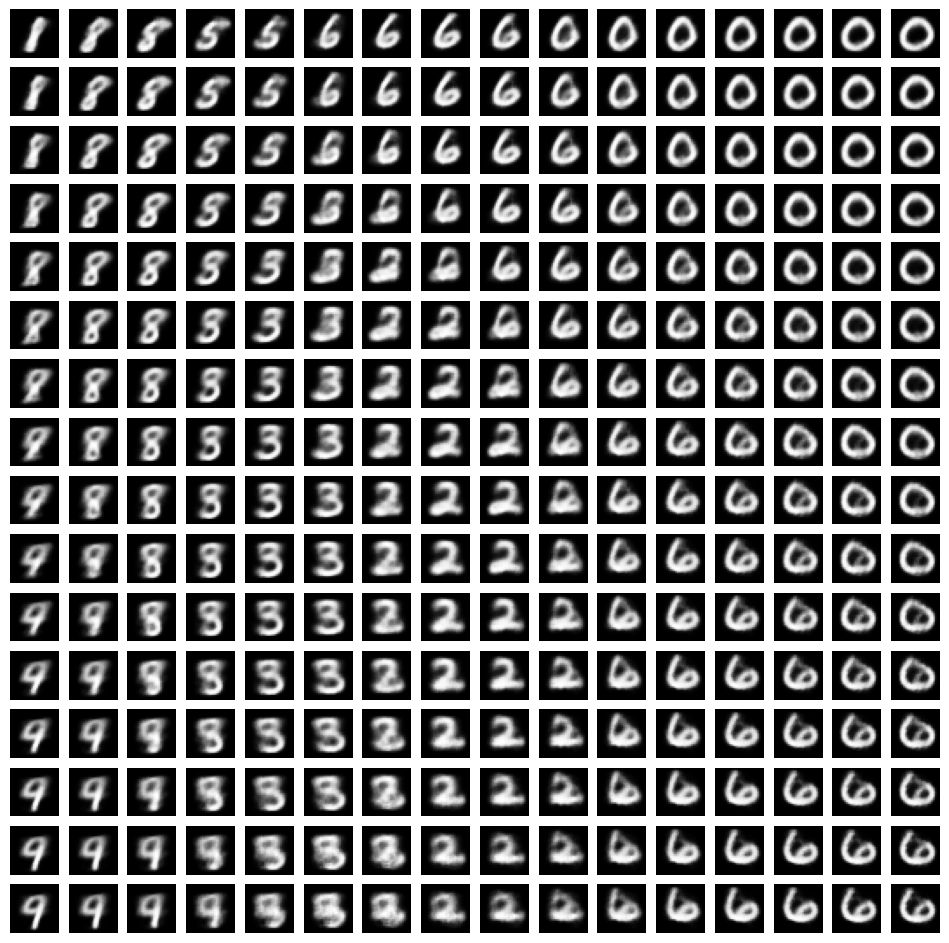

In [8]:
k = 0
n = 16
scale = 1

plt.figure(figsize=(12, 12))
grid_x = np.linspace(-scale, scale, 16)
grid_y = np.linspace(-scale, scale, 16)

for i in grid_x:
    for j in grid_y:
        ax = plt.subplot(n, n, k+1)
        input = tf.constant([[i, j]])
        # vae.layers[2].predict(tf.constant([[-1, 1]])).shape is (1, 28, 28, 1)
        # vae.layers[2].predict(tf.constant([[-1, 1]]))[0][..., 0].shape is (28, 28)
        out = model.decoder.predict(input)[0][..., 0]
        plt.imshow(out, cmap="Greys_r")
        plt.axis('off')
        k += 1

1875/1875 [==============================] - 3s 2ms/step


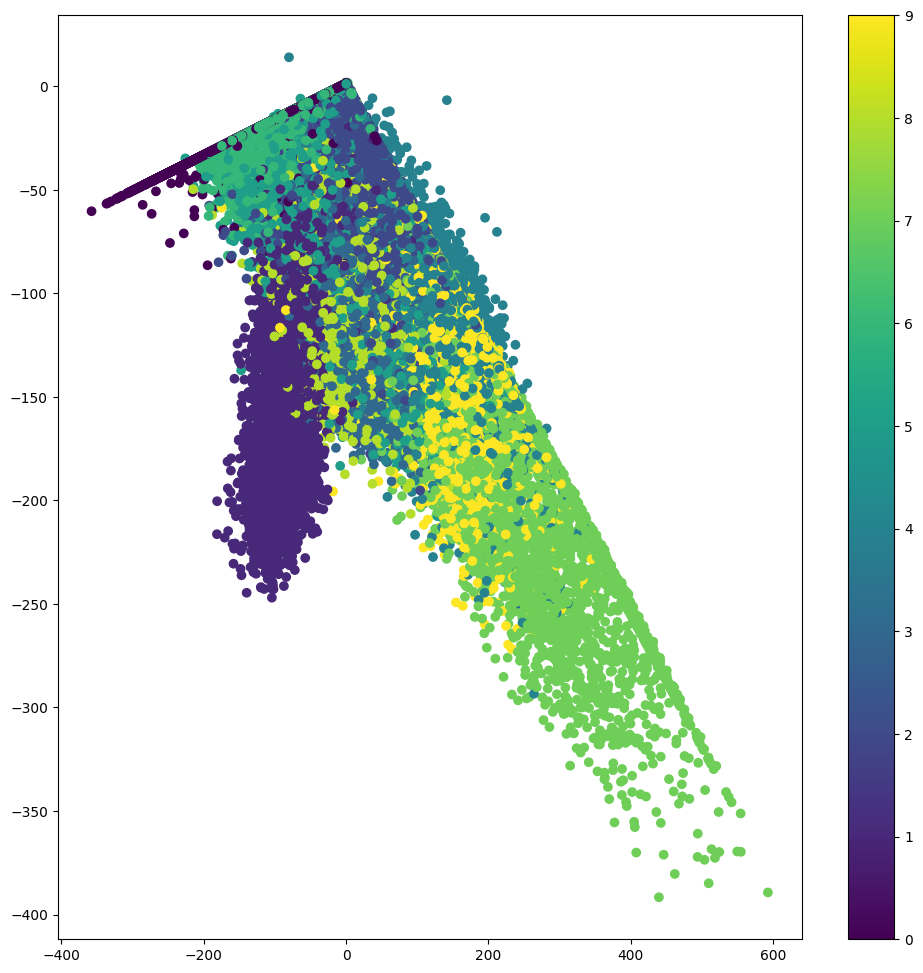

In [10]:
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
z, _, _ = vae.layers[1].predict(x_train)
plt.figure(figsize=(12, 12))
plt.scatter(z[:, 0], z[:, 1], c=y_train)
plt.colorbar()
plt.show()